In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as layers
from PIL import Image


from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [2]:
# Inlezen, filteren en splitten van data


data_dir = 'Train'



train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=123, image_size=(224, 224), batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', seed=123, image_size=(224, 224), batch_size=32
)

test_dir = 'Test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=123, image_size=(224, 224), shuffle=False, batch_size=32)


class_names = train_ds.class_names

num_classes = len(class_names)

Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.
Found 120 files belonging to 4 classes.


In [3]:
# Preprocess:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Rescale:
#tf.keras.layers.Rescaling(scale=1./255)

# Add augmentation:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [4]:
img_height = 224
img_width = 224
IMG_SIZE = img_width, img_height
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained model MobileNet V2

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# base_model.summary()

In [5]:
base_model.trainable = False

In [6]:
# Feature extraction

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 7, 7, 1280)
(32, 1280)


In [7]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = tf.keras.layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
modelX = tf.keras.Model(inputs, outputs)

In [9]:
base_learning_rate = 0.0001
modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#modelX.summary()

# len(modelX.trainable_variables)

In [10]:
initial_epochs = 25

loss0, accuracy0 = modelX.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

3/3 [==============================] - 2s 238ms/step - loss: 1.5254 - accuracy: 0.2763
initial loss: 1.53
initial accuracy: 0.28


In [11]:
history = modelX.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/25
10/10 [==============================] - 6s 466ms/step - loss: 1.6128 - accuracy: 0.3301 - val_loss: 1.3905 - val_accuracy: 0.3947
Epoch 2/25
10/10 [==============================] - 5s 458ms/step - loss: 1.5498 - accuracy: 0.3268 - val_loss: 1.2969 - val_accuracy: 0.4474
Epoch 3/25
10/10 [==============================] - 5s 450ms/step - loss: 1.4748 - accuracy: 0.3758 - val_loss: 1.2227 - val_accuracy: 0.5000
Epoch 4/25
10/10 [==============================] - 5s 438ms/step - loss: 1.4078 - accuracy: 0.3791 - val_loss: 1.1574 - val_accuracy: 0.4868
Epoch 5/25
10/10 [==============================] - 5s 445ms/step - loss: 1.2811 - accuracy: 0.4248 - val_loss: 1.1010 - val_accuracy: 0.5395
Epoch 6/25
10/10 [==============================] - 5s 448ms/step - loss: 1.2639 - accuracy: 0.4248 - val_loss: 1.0515 - val_accuracy: 0.5658
Epoch 7/25
10/10 [==============================] - 5s 479ms/step - loss: 1.1773 - accuracy: 0.4804 - val_loss: 1.0066 - val_accuracy: 0.6053
Epoch 

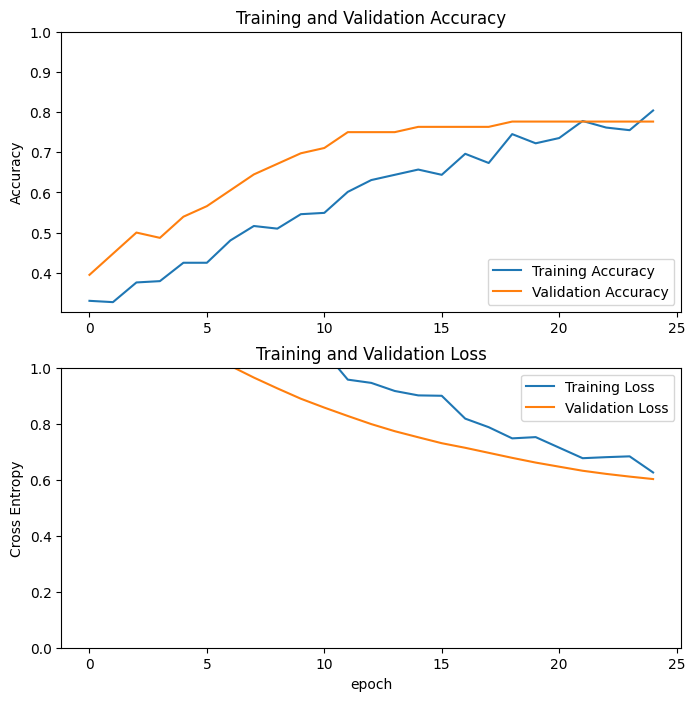

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# Unfreeze

base_model.trainable = True

In [14]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [15]:
modelX.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

In [16]:
len(modelX.trainable_variables)

56

In [17]:
# Continue training

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 25/35
10/10 [==============================] - 9s 645ms/step - loss: 0.5633 - accuracy: 0.8039 - val_loss: 0.4463 - val_accuracy: 0.8026
Epoch 26/35
10/10 [==============================] - 6s 604ms/step - loss: 0.4017 - accuracy: 0.8562 - val_loss: 0.4076 - val_accuracy: 0.8421
Epoch 27/35
10/10 [==============================] - 7s 648ms/step - loss: 0.3077 - accuracy: 0.8856 - val_loss: 0.3874 - val_accuracy: 0.8684
Epoch 28/35
10/10 [==============================] - 7s 713ms/step - loss: 0.2825 - accuracy: 0.9052 - val_loss: 0.3551 - val_accuracy: 0.8553
Epoch 29/35
10/10 [==============================] - 7s 714ms/step - loss: 0.2269 - accuracy: 0.9379 - val_loss: 0.3558 - val_accuracy: 0.8421
Epoch 30/35
10/10 [==============================] - 7s 694ms/step - loss: 0.1967 - accuracy: 0.9412 - val_loss: 0.3915 - val_accuracy: 0.8684
Epoch 31/35
10/10 [==============================] - 7s 682ms/step - loss: 0.1783 - accuracy: 0.9444 - val_loss: 0.3052 - val_accuracy: 0.8684

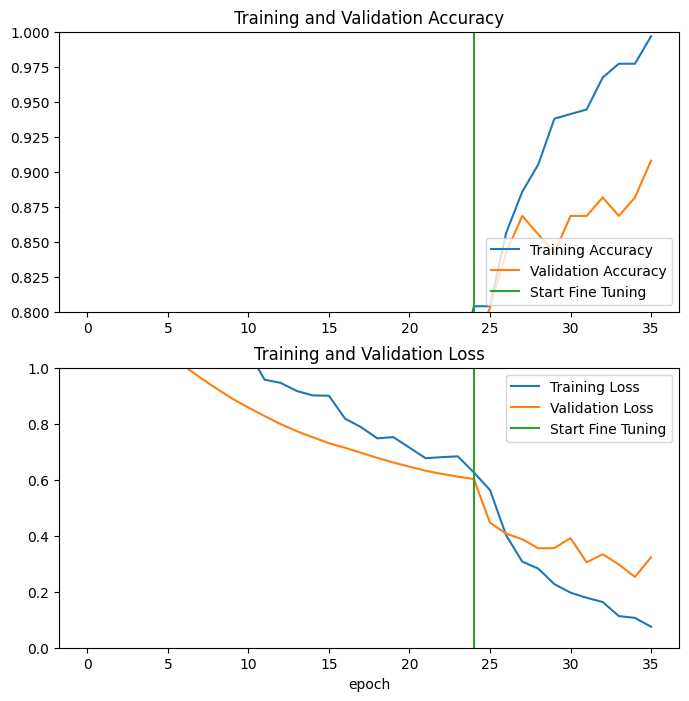

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

4/4 [==============================] - 1s 342ms/step - loss: 0.7135 - accuracy: 0.7750
Test accuracy : 0.7749999761581421
Predictions:
 [1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0
 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
4/4 [==============================] - 1s 331ms/step - loss: 0.7135 - accuracy: 0.7750
Test accuracy : 0.7749999761581421


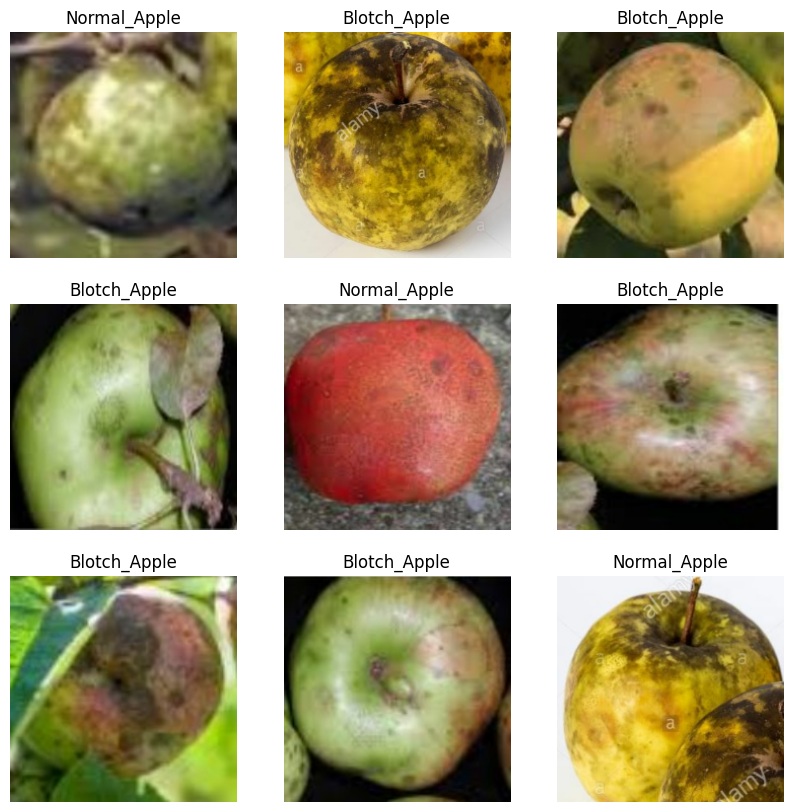

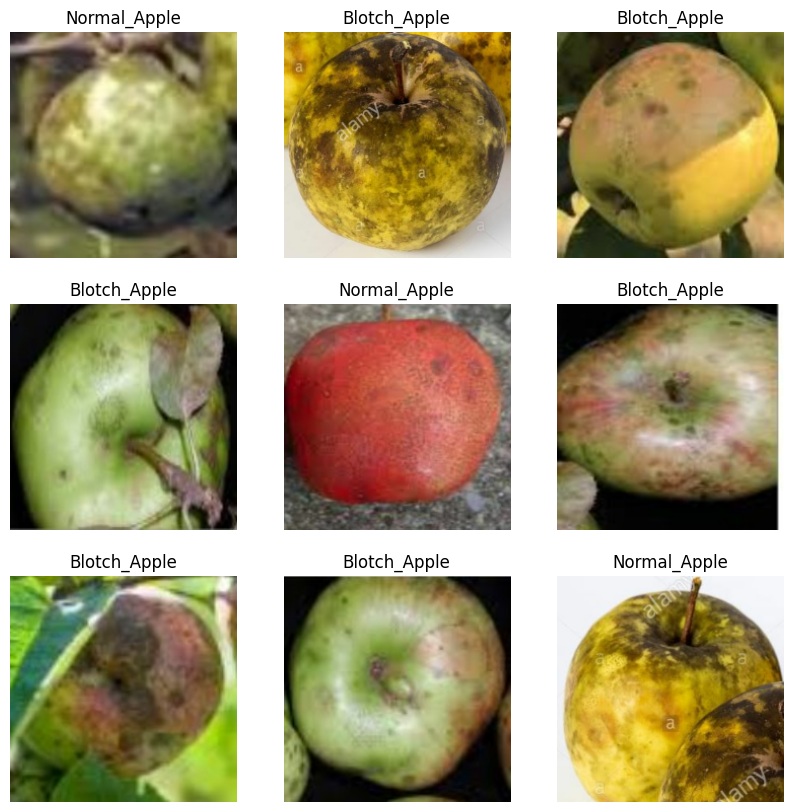

In [32]:

loss, accuracy = modelX.evaluate(test_ds)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = modelX.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")



def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

loss, accuracy = modelX.evaluate(test_ds)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = modelX.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1 )

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Found 120 files belonging to 4 classes.


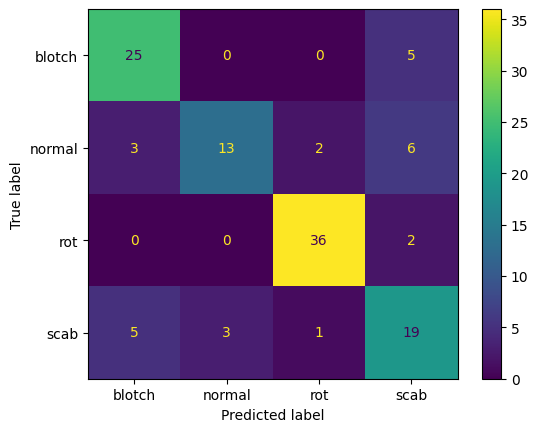

In [33]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay


test_dir = 'Test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=123, image_size=(224, 224), shuffle=False, batch_size=32
)


batchPredictions = modelX.predict(test_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)

cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])

cmd.plot()

In [34]:
modelX.save('C:/Users/vande/MakeAIWork/MakeAIWork2/projects/apple_disease_classification/data/MobileNetV2')

INFO:tensorflow:Assets written to: C:/Users/vande/MakeAIWork/MakeAIWork2/projects/apple_disease_classification/data/MobileNetV2\assets


Found 120 files belonging to 4 classes.


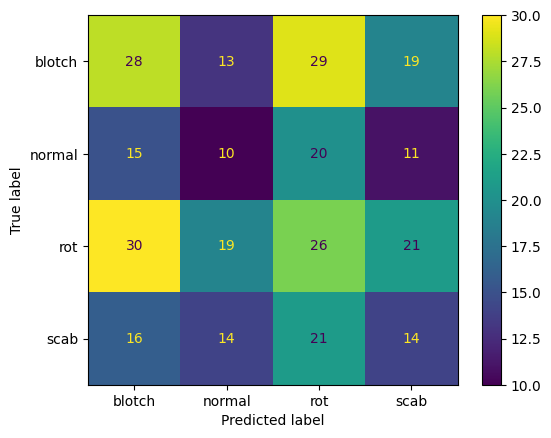

In [37]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

test_dir = 'Test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, seed=123, image_size=(224, 224), shuffle=False, batch_size=32
)


batchPredictions = modelX.predict(train_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)

cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])

cmd.plot()


In [36]:
modelX.evaluate(test_ds)

4/4 [==============================] - 1s 335ms/step - loss: 0.7135 - accuracy: 0.7750


[0.7134799957275391, 0.7749999761581421]